In [1]:
import maze_library
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf


2025-03-25 23:01:46.278352: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742943706.292507 2969772 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742943706.296550 2969772 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-25 23:01:46.312686: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def map_int_to_direction(input):
    if input == 0:
        return maze_library.Direction.North
    if input == 1:
        return maze_library.Direction.East
    if input == 2:
        return maze_library.Direction.South
    else:
        return maze_library.Direction.West

In [3]:
env = maze_library.init_environment_python(10,10)
maze_library.create_kruzkals_maze(env)
maze_library.make_maze_imperfect(env)

In [4]:
def action_result_to_tuple(action_result):
    """
    Converts an ActionResult object into a tuple.

    Args:
        action_result (ActionResult): The result of an action in the environment.

    Returns:
        tuple: (observation, reward, done, truncated, info)
    """
    observation = action_result.observation  # The new observation after taking action
    reward = action_result.reward  # Reward received
    done = action_result.is_done  # Whether the episode is finished
    truncated = action_result.is_truncated  # Whether the episode was truncated
    info = action_result.info # Additional info

    return observation, reward, done, truncated, info


In [5]:
def action_result_to_input_vector(state, info):
    available_paths = state.available_paths
    visited_paths = state.visited_paths
    return np.array([
        available_paths.get(maze_library.Direction.North, 0)/10,
        1 if visited_paths.get(maze_library.Direction.North, False) else 0,
        available_paths.get(maze_library.Direction.East, 0)/10,
        1 if visited_paths.get(maze_library.Direction.East, False) else 0,
        available_paths.get(maze_library.Direction.South, 0)/10,
        1 if visited_paths.get(maze_library.Direction.South, False) else 0,
        available_paths.get(maze_library.Direction.West, 0)/10,
        1 if visited_paths.get(maze_library.Direction.West, False) else 0,
        state.current_location[0] / 10,
        state.current_location[1] / 10,
        info.previous_node[0] / 10,
        info.previous_node[1] / 10,
        state.end_node[0] / 10,
        state.end_node[1] / 10,
        info.manhattan_distance / 10,
        info.goal_dx/5,
        info.goal_dy/5,
        1 if info.visited_node else 0

    ])

In [6]:
tf.random.set_seed(42)  # extra code – ensures reproducibility on the CPU

input_shape = [18]  # == env.observation_space.shape
n_outputs = 4  # == env.action_space.n

model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation="elu", input_shape=input_shape),
    tf.keras.layers.Dense(64, activation="elu"),
    tf.keras.layers.Dense(n_outputs)
])

/home/art/Development/FYP/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1742943707.964118 2969772 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4701 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1060 6GB, pci bus id: 0000:06:00.0, compute capability: 6.1


In [7]:
def epsilon_greedy_policy(flat_state, epsilon):
    if np.random.rand() < epsilon:
        # Choose only from valid actions
        return np.random.choice(n_outputs)
    else:
        Q_values = model.predict(flat_state[np.newaxis], verbose=0)[0]
        return Q_values.argmax()


In [8]:
from collections import deque

replay_buffer = deque(maxlen=8000)

In [9]:
def sample_experiences(batch_size):
    indices = np.random.randint(len(replay_buffer), size=batch_size)
    batch = [replay_buffer[index] for index in indices]
    return [
        np.array([experience[field_index] for experience in batch])
        for field_index in range(6)
    ]  # [states, actions, rewards, next_states, dones, truncateds]

In [10]:
reward_log = []
def play_one_step(env, state, info, epsilon):
    flat_state = action_result_to_input_vector(state, info)
    action = epsilon_greedy_policy(flat_state, epsilon)
    action_obj = maze_library.create_action(map_int_to_direction(action))
    next_state, reward, done, truncated, new_info = action_result_to_tuple(env.take_action(action_obj))
    flat_next_state = action_result_to_input_vector(next_state, new_info)
    reward_log.append(reward)
    replay_buffer.append((flat_state, action, reward, flat_next_state, done, truncated))
    return next_state, reward, done, truncated, info

In [11]:
np.random.seed(42)
tf.random.set_seed(42)
rewards = [] 
highest_reward = -1000000

In [12]:
batch_size = 32
discount_factor = 0.96
q_value_log = []
optimizer = tf.keras.optimizers.Nadam(learning_rate=1e-4)
loss_fn = tf.keras.losses.Huber(delta=1.0) # Use the class
def training_step(batch_size):
    experiences = sample_experiences(batch_size)
    states, actions, rewards, next_states, dones, truncateds = experiences
    next_Q_values = model.predict(next_states, verbose=0)
    max_next_Q_values = next_Q_values.max(axis=1)
    runs = 1.0 - (dones)  # episode is not done or truncated
    target_Q_values = rewards + runs * discount_factor * max_next_Q_values
    target_Q_values = target_Q_values.reshape(-1, 1)
    
    mask = tf.one_hot(actions, n_outputs)
    with tf.GradientTape() as tape:
        all_Q_values = model(states)
        Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
        q_value_log.extend(Q_values.numpy().flatten())
        loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))

    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

In [13]:
# Visualization function
def plot_q_values():
    plt.figure(figsize=(10, 5))
    plt.plot(q_value_log)
    plt.title("Q-Values Over Time")
    plt.xlabel("Training Steps")
    plt.ylabel("Q-Value")
    plt.grid(True)
    plt.show()


Episode: 0, Steps: 472, eps: 1.000, reward = -244.49999999999994


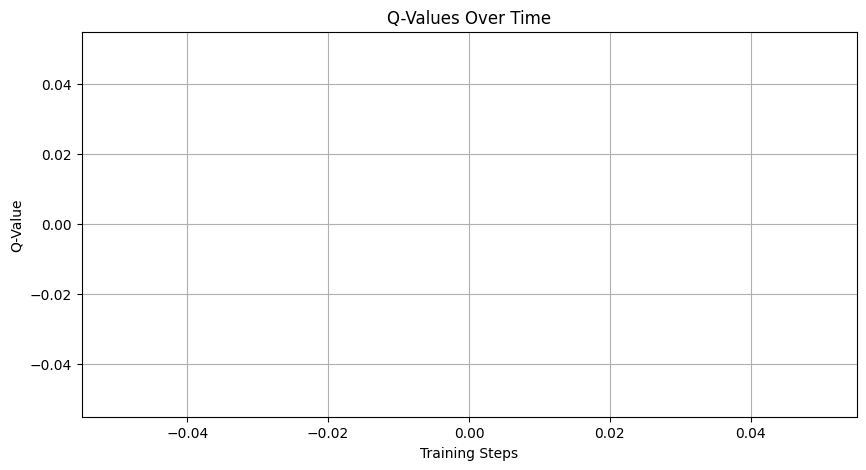

I0000 00:00:1742943709.173044 2969840 service.cc:148] XLA service 0x7fa054004cd0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1742943709.173104 2969840 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce GTX 1060 6GB, Compute Capability 6.1
I0000 00:00:1742943709.181622 2969840 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1742943709.280468 2969840 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Episode: 1, Steps: 470, eps: 0.989, reward = -231.2999999999999
Episode: 2, Steps: 449, eps: 0.978, reward = -243.09999999999985
Episode: 3, Steps: 499, eps: 0.967, reward = -267.7999999999999
Episode: 4, Steps: 333, eps: 0.956, reward = -158.0
Episode: 5, Steps: 445, eps: 0.944, reward = -220.6999999999999
Episode: 6, Steps: 481, eps: 0.933, reward = -245.8999999999999
Episode: 7, Steps: 453, eps: 0.922, reward = -213.7
Episode: 8, Steps: 480, eps: 0.911, reward = -228.7999999999999
Episode: 9, Steps: 426, eps: 0.900, reward = -189.2
Episode: 10, Steps: 430, eps: 0.889, reward = -213.20000000000002
Episode: 11, Steps: 499, eps: 0.878, reward = -267.6999999999997
Episode: 12, Steps: 499, eps: 0.867, reward = -292.79999999999984
Episode: 13, Steps: 428, eps: 0.856, reward = -201.8000000000001
Episode: 14, Steps: 499, eps: 0.844, reward = -285.19999999999993
Episode: 15, Steps: 413, eps: 0.833, reward = -192.9
Episode: 16, Steps: 478, eps: 0.822, reward = -243.89999999999998
Episode: 17,

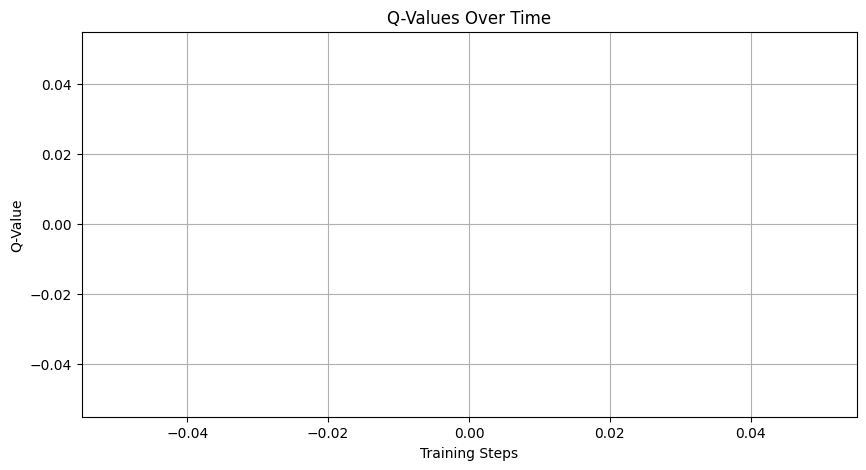

Episode: 21, Steps: 499, eps: 0.767, reward = -292.0000000000001
Episode: 22, Steps: 468, eps: 0.756, reward = -245.79999999999976
Episode: 23, Steps: 456, eps: 0.744, reward = -216.49999999999994
Episode: 24, Steps: 442, eps: 0.733, reward = -223.2000000000001
Episode: 25, Steps: 491, eps: 0.722, reward = -256.50000000000006
Episode: 26, Steps: 499, eps: 0.711, reward = -297.2999999999999
Episode: 27, Steps: 428, eps: 0.700, reward = -225.60000000000002
Episode: 28, Steps: 66, eps: 0.689, reward = -20.09999999999999
Episode: 29, Steps: 493, eps: 0.678, reward = -270.9999999999999
Episode: 30, Steps: 499, eps: 0.667, reward = -267.0999999999999
Episode: 31, Steps: 491, eps: 0.656, reward = -265.20000000000005
Episode: 32, Steps: 468, eps: 0.644, reward = -252.79999999999993
Episode: 33, Steps: 429, eps: 0.633, reward = -205.3
Episode: 34, Steps: 499, eps: 0.622, reward = -328.59999999999997
Episode: 35, Steps: 499, eps: 0.611, reward = -293.59999999999985
Episode: 36, Steps: 499, eps: 

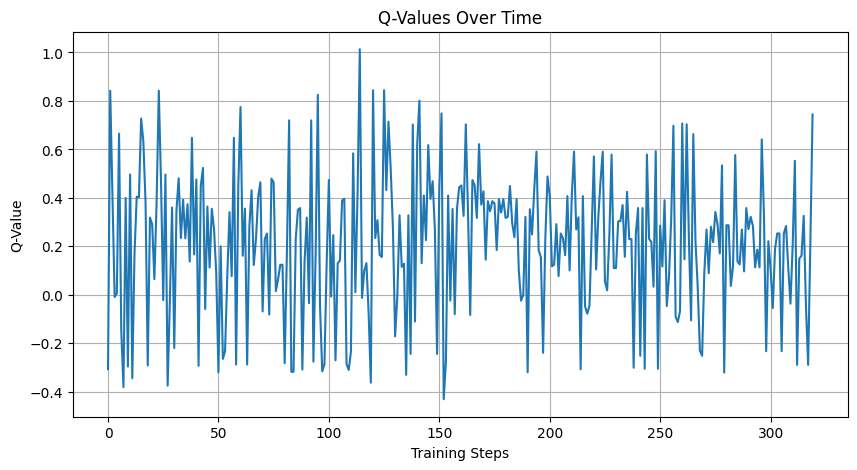

Episode: 41, Steps: 482, eps: 0.544, reward = -286.49999999999994
Episode: 42, Steps: 499, eps: 0.533, reward = -344.8999999999999
Episode: 43, Steps: 418, eps: 0.522, reward = -278.79999999999995
Episode: 44, Steps: 403, eps: 0.511, reward = -221.99999999999977
Episode: 45, Steps: 335, eps: 0.500, reward = -191.69999999999993
Episode: 46, Steps: 352, eps: 0.489, reward = -161.69999999999982
Episode: 47, Steps: 356, eps: 0.478, reward = -178.49999999999991
Episode: 48, Steps: 398, eps: 0.467, reward = -218.19999999999982
Episode: 49, Steps: 356, eps: 0.456, reward = -197.49999999999997
Episode: 50, Steps: 357, eps: 0.444, reward = -180.2999999999997
Episode: 51, Steps: 499, eps: 0.433, reward = -314.3999999999997
Episode: 52, Steps: 301, eps: 0.422, reward = -126.50000000000007
Episode: 53, Steps: 274, eps: 0.411, reward = -167.79999999999978
Episode: 54, Steps: 409, eps: 0.400, reward = -262.1999999999995
Episode: 55, Steps: 378, eps: 0.389, reward = -190.79999999999976
Episode: 56, S

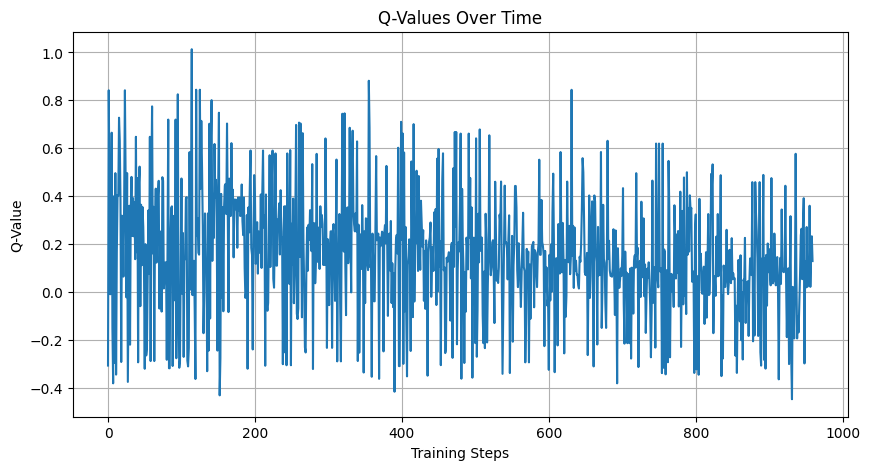

Episode: 61, Steps: 363, eps: 0.322, reward = -186.49999999999952
Episode: 62, Steps: 252, eps: 0.311, reward = -122.10000000000014
Episode: 63, Steps: 242, eps: 0.300, reward = -114.30000000000017
Episode: 64, Steps: 304, eps: 0.289, reward = -155.79999999999998
Episode: 65, Steps: 239, eps: 0.278, reward = -129.0000000000002
Episode: 66, Steps: 283, eps: 0.267, reward = -173.09999999999968
Episode: 67, Steps: 279, eps: 0.256, reward = -156.10000000000014
Episode: 68, Steps: 266, eps: 0.244, reward = -169.5999999999998
Episode: 69, Steps: 288, eps: 0.233, reward = -193.29999999999947
Episode: 70, Steps: 219, eps: 0.222, reward = -125.0000000000002
Episode: 71, Steps: 315, eps: 0.211, reward = -180.59999999999943
Episode: 72, Steps: 304, eps: 0.200, reward = -176.39999999999986
Episode: 73, Steps: 243, eps: 0.189, reward = -142.10000000000005
Episode: 74, Steps: 290, eps: 0.178, reward = -166.59999999999985
Episode: 75, Steps: 321, eps: 0.167, reward = -187.09999999999943
Episode: 76, 

In [ ]:
steps = 500

for episode in range(100):
    result = env.reset()   
    obs, reward, done, truncated, info = action_result_to_tuple(result)
    cumilative_reward = 0
    for step in range(steps):
        epsilon = max(1 - episode / 90, 0.01)
        obs, reward, done, truncated, info = play_one_step(env, obs, info, epsilon)
        cumilative_reward += reward
        if done or truncated:
            break

    # Extra debug information
    print(f"\rEpisode: {episode}, Steps: {step}, eps: {epsilon:.3f}, reward = {cumilative_reward}")
    rewards.append(cumilative_reward)
    
    if cumilative_reward >= highest_reward:
        best_weights = model.get_weights()
        highest_reward = cumilative_reward

    if episode > 30:
        training_step(batch_size)
    if episode % 20 == 0:
        plot_q_values()
        
    with open(f'../mazeLogs/solve{episode}.json', 'w') as file:
        file.write(env.to_json_python())

    
        
model.set_weights(best_weights)  # extra code – restores the best model weights

In [ ]:
# extra code – this cell generates and saves Figure 18–10
plt.figure(figsize=(8, 4))
plt.plot(rewards)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Sum of rewards", fontsize=14)
plt.grid(True)
plt.show()

In [ ]:
plt.figure(figsize=(10, 5))
plt.hist(reward_log, bins=20, edgecolor='black')
plt.title("Reward Distribution")
plt.xlabel("Reward")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()